# Bayesian Ranking Notes
1. [Prerequisites](#prerequisite)
2. [Bayesian Approach](#bayesian) using Bernoulli as an example
3. [Sampling and Ranking](#sr)
4. [What if your likelihood is not Bernoulli?](#gaussian)
5. [Code](#code)

## <a id='prerequisite'>1. Prerequisite </a>

Using CTR as an example. We know that the maximum likelihood estimate of the click through rate is just the number of clicks divided by the number of impressions. However, we know that again, using the maximum likelihood estimate is just like the average. It's not a great idea. Using the average does not account for the explore exploit dilemma.

<img src="intro1.png" alt="score" width="500" height="200">
The goal of MLE is to find an optimal way to fit a distribution to the data. The reason to fit a distribution to your data is that it can be easier to work with and it is also more general - it applies to every experiment of the same type.
<img src="intro2.png" alt="score" width="500" height="200">

Well, you should also recognize that the maximum likelihood estimate exactly corresponds to the average ratings and click through rates that we have been discussing so far. So obviously, they are very relevant. More importantly, the likelihood is just one of the central items in the Bayesian approach. The Bayesian approach can be thought of as building on top of the likelihood.

<img src="intro3.png" alt="score" width="500" height="200" style="float:left;">
<img src="intro4.png" alt="score" width="500" height="200" style="float:left;">


## <a id='bayesian'>2. Bayesian Approach to the Explore-Exploit Dilemma</a>

Main theme: everything is a random variable, and RVs have a probability distribution, parameters, ... 

$\pi$ in Bernoulli is also a RV, that is beta distributed.
<img src="intro6.png" alt="score" width="500" height="200">

Remember that in Bayesian, everything is a RV, so not a fixed value, rather they have probability distributions.
<img src="intro7.png" alt="score" width="500" height="200">

How to calculate this distribution?
<img src="intro8.png" alt="score" width="500" height="200">
<img src="intro9.png" alt="score" width="500" height="200">
<img src="intro10.png" alt="score" width="500" height="200">
<img src="intro11.png" alt="score" width="400" height="200">
<img src="intro12.png" alt="score" width="400" height="200">


## <a id='sr'>3. Sampling and Ranking</a>

<img src="intro13.png" alt="score" width="500" height="200">


## <a id='gaussian'>4. Gaussian Likelihood</a>

<img src="intro14.png" alt="score" width="500" height="200">
Remember theta is not a fixed value but a RV with prob distribution.
<img src="intro15.png" alt="score" width="500" height="200">
<img src="intro16.png" alt="score" width="500" height="200">
We show the work on the first case.
<img src="intro17.png" alt="score" width="500" height="200">

## <a id='code'>5. Code</a>
Check out the **bayesian_bandit.py** for clean code.

Problem setup: you're playing a set of slot machines. In this problem, you can only win or lose, but we don't consider any particular monetary reward, so the outcomes are binary. Therefore, we're using a Bernoulli likelihood and a beta prior.

I would like to play the slot machines using the Bayesian approach. So that means instead of playing each slot machine one at a time in an effort to collect more data, instead on each round, I'm going to rank each bandit according to samples drawn from their posteriors.

So that means I'm going to model each slot machine as a separate beta distribution, and that's going to model each slot machines win rate. Then in a loop, I'm going to draw a sample from each of my beta distributions and then sort them in order. This is my ranking and that's exactly the order I would use to rank the items in a recommendation system.

Then what I'm going to do is pick the top item and play that slot machine only.

In [3]:
from __future__ import print_function, division
from builtins import range

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

In [5]:
NUM_TRIALS = 2000
# true bandit probability
# in real life, you do not know these
# we are testing our algorithm to make sure it arrives at the right answer
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75] 

In [10]:
class Bandit(object):
    def __init__(self, p):
        self.p = p # true success rate
        self.a = 1 # beta priors
        self.b = 1 # beta priors
        self.N = 0 # for information only

    
    def pull(self):
        # draw a sample from the bernoulli distribution with parameter p
        # i.e., draw from true distribution
        return np.random.random() < self.p
    
    def sample(self):
        # draw a sample from the a beta distribution which is parameterized by a and b
        # i.e., draw from posterior distribution
        return np.random.beta(self.a, self.b)
    
    def update(self, x):
        self.a += x
        self.b += 1 - x
        self.N += 1

You might ask, why don't we just draw samples from the true distribution using the pull method?

Of course, if you're playing a slot machine, that would be very expensive. Every time you pull the slot machine arm, you have to pay money. So of course, you don't want to do that.

In the case of, say, a news site, that would mean showing a suboptimal article to your users so you don't want to do something like that. Instead, you want to sample from your model, which is the beta distribution.

In [11]:
# plot the distribution of each priors
# This just loops through each bandit and plots the beta pdf for each bandit.
def plot(bandits, trial):
    x = np.linspace(0, 1, 200)
    for b in bandits:
        y = beta.pdf(x, b.a, b.b)
        plt.plot(x, y, label=f"real p: {b.p:.4f}, win rate = {b.a - 1}/{b.N}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()

In each trial
- we first sample to get the best bandit (currently believe)
- then pull the best bandit

In [12]:
def experiment():
    bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]
    
    #These are iterations we want our algorithm to stop and make a plot so we can observe how things are progressing.
    sample_points = [5, 10, 20, 40, 100, 200, 500, 1000, 1500, 1999]
    
    for i in range(NUM_TRIALS):
        
        # take a sample from each bandit
        bestbandit = None
        maxsample = -1
        allsamples = [] # lets collect these just to print for debugging
        
        for b in bandits:
            sample = b.sample()
            allsamples.append("%.4f" % sample)
            if sample > maxsample:
                maxsample = sample
                bestbandit = b 
        if i in sample_points:
            print("current samples: %s" % allsamples)
            plot(bandits, i)
        
        # pull the bandit arm with the largest sample
        x = bestbandit.pull()
        
        # update the distribution for the bandit whose arm was just pulled
        bestbandit.update(x)

current samples: ['0.3186', '0.5425', '0.9527']


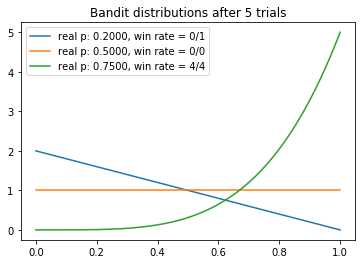

current samples: ['0.4750', '0.6693', '0.6839']


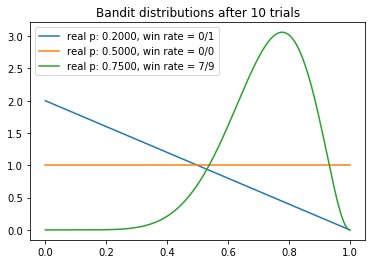

current samples: ['0.3975', '0.6971', '0.5674']


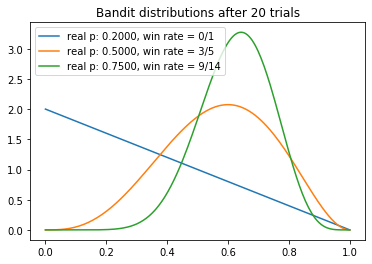

current samples: ['0.6902', '0.6031', '0.7506']


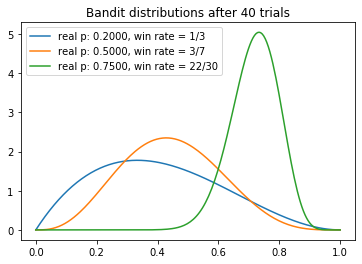

current samples: ['0.7312', '0.2727', '0.6835']


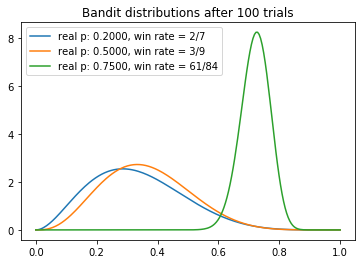

current samples: ['0.4579', '0.3462', '0.6831']


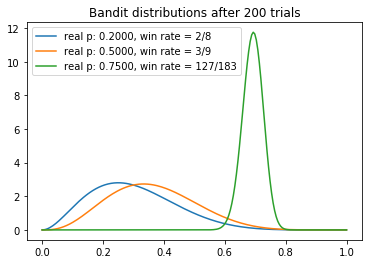

current samples: ['0.1647', '0.6237', '0.7434']


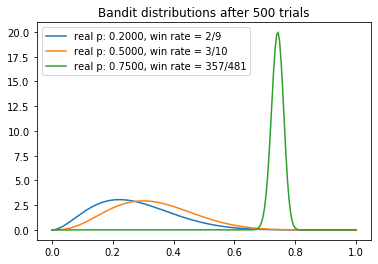

current samples: ['0.6422', '0.2492', '0.7182']


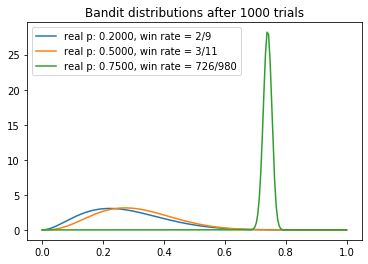

current samples: ['0.2084', '0.1851', '0.7489']


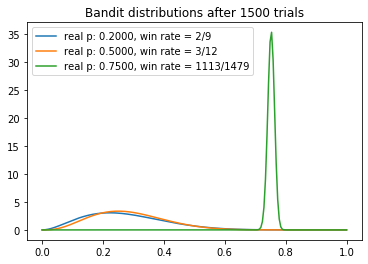

current samples: ['0.2156', '0.4502', '0.7211']


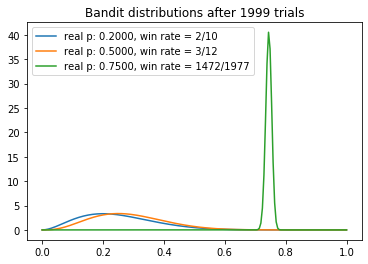

In [13]:
experiment()